In [1]:
import os
import math
import openturns as ot
import numpy as np
import openturns.viewer as viewer

from tqdm.notebook import tqdm
from functools import partial, lru_cache
from matplotlib import pylab as plt
from matplotlib import cm
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
from joblib import Parallel, delayed
from scipy.optimize import minimize, Bounds, LinearConstraint

In [3]:
def npmap2d(fun, xs, ys, multi_output=False):
    """
    
    #https://stackoverflow.com/questions/22774726/numpy-evaluate-function-on-a-grid-of-points
    Evaluate a function on a grid of points.

    Parameters:
        fun (callable): The function to evaluate.
        xs (array_like): 1-D array of x-coordinates.
        ys (array_like): 1-D array of y-coordinates.
        fun_arg (int, optional): Index of the function output to return (default: None).

    Returns:
        X (ndarray): 2-D array of x-coordinates.
        Y (ndarray): 2-D array of y-coordinates.
        Z (ndarray): 2-D array of function values.
    """
    # Create 2D grid of x and y coordinates
    X, Y = np.meshgrid(xs, ys)

    # Evaluate the function on the grid
    Z_results = [fun(x, y) for x, y in tqdm(zip(X.flat, Y.flat), total=X.size, desc='Progress')]

    if not multi_output:
        Z = np.array(Z_results).reshape(X.shape)
    else :
        Z = list(zip(*Z_results))
    
    return X, Y, Z

# Analyse des tolerances d'un modèle minimal à deux pièces à but démonstratif. 

#### Modèle d'assemblage pour analyse des tolérances

In [4]:
X1, X2, X3 = 99.8, 100, 10 #Respectivement la largeur male, femelle et la hauteur

def min_difference_upper_lower_gaps(u_d_1, gamma_d_1, u_d_2, gamma_d_2, X1=X1, X2=X2, X3=X3, return_new_dimensions=False):
    """
    Calculate the minimum difference between the upper and lower gaps for a given set of defects.

    Parameters:
        u_d_1 (float): Translational defect of part 1
        gamma_d_1 (float): Rotational defect of part 1
        u_d_2 (float): Translational defect of part 2
        gamma_d_2 (float): Rotational defect of part 2
        rnd (int, optional): Number of decimal places to round the result (default: 6). - in mm

    Returns:
        float: The minimum play for the given set of defects.
    """
    # Calculate intermediate results
    X1_upper = X1 + u_d_1 - (X3/2) * gamma_d_1
    X1_lower = X1 + u_d_1 + (X3/2) * gamma_d_1
    X2_upper = X2 - u_d_2 - (X3/2) * gamma_d_2
    X2_lower = X2 - u_d_2 + (X3/2) * gamma_d_2

    # Calculate minimum difference between upper and lower gaps
    jeu_min = np.squeeze(np.minimum(X2_upper - X1_upper, X2_lower - X1_lower))
    
    if not return_new_dimensions:
        return jeu_min
    else:
        return jeu_min, (X1_upper, X1_lower, X2_upper, X2_lower)

In [5]:
min_difference_upper_lower_gaps(0.10130575, -0.01944775,  0.11796087, -0.01720675)

-0.030471620000000144

#### Lois probabilistes pilotant les défauts 

In [6]:
IT = 0.2
tol = IT/2
Cm = 0.3
# Moyennes des lois toutes nulles.
sigma_translation = IT / (6 * Cm)
e_pos = ot.Normal(0, sigma_translation)
e_pos.setDescription(["e_pos"])

# Le défaut en orientation est piloté par une incertitude sur un angle. On suppose les angles petits << 1 rad
theta_max = IT / X3
sigma_rotation = (2*theta_max) / (6*Cm)
e_theta = ot.Normal(0, sigma_rotation)
e_theta.setDescription(["e_theta"])

ref_means = np.array([0.0]*4)
ref_standards = np.array([sigma_translation, sigma_rotation, sigma_translation, sigma_rotation])

In [7]:
print('Reference standard deviations:', ref_standards.round(4))
print('Reference means:', ref_means)

Reference standard deviations: [0.1111 0.0222 0.1111 0.0222]
Reference means: [0. 0. 0. 0.]


#### Echantillons des lois

In [8]:
SEED = 321654987 #123456789 # 147258369 
ot.RandomGenerator.SetSeed(SEED)
N1 = int(1e6)
ref_sample_U1 = np.squeeze(e_pos.getSample(N1))
ref_sample_G1 = np.squeeze(e_theta.getSample(N1))
ref_sample_U2 = np.squeeze(e_pos.getSample(N1))
ref_sample_G2 = np.squeeze(e_theta.getSample(N1))

ref_samples = np.column_stack([ref_sample_U1, ref_sample_G1, ref_sample_U2, ref_sample_G2])
ref_samples.shape

(1000000, 4)

#### Fonctions contrainte sur les paramètres λ d'allocation de défauts

In [9]:
const_tol = 1e-12
constraint_matrix = np.array([[1.,1.,0,0],[0,0,1.,1.]])
constraint_lb = np.array([1.,1.])
constraint_ub = np.array([1.+const_tol,1.+const_tol])
constraints_lambda = LinearConstraint(constraint_matrix, constraint_lb, constraint_ub)

In [10]:
constraint_matrix.shape

(2, 4)

In [11]:
def equality_constraint_function(lambdas, constraint_matrix=constraint_matrix, equality_matrix=constraint_lb):
    eq_constraint = constraint_matrix@lambdas - equality_matrix
    return eq_constraint

def equality_constraint_function_jacobian(lambdas, constraint_matrix=constraint_matrix, equality_matrix=constraint_lb):
    return np.array([1.,1.,1.,1.])

#### Définition des bornes d'existance des paramètres λ 

In [12]:
bounds_tol = 1e-11
bounds_labmda = Bounds(lb=[bounds_tol]*4, ub=[1-bounds_tol]*4)

#### Fonction "Monte-Carlo Naive" pour trouver la probabilité d'avoir un jeu inferieur a un seuil en fonction des paramètres lambda

In [13]:
def gaussian_log_gradient_mean(sample, mean, standard):
    return (1/standard)*((sample-mean)/standard)

def gaussian_log_gradient_standard(sample, mean, standard):
    return (1/standard)*(np.square((sample-mean)/standard) - 1)

def intermediate_lambda_function(lambdas):
    return np.sqrt(lambdas)

def intermediate_lambda_function_derivate(lambdas):
    return 1/(2*np.sqrt(lambdas))

def lambda_sigma_compose(lambdas, ref_samples = ref_samples):
    return ref_samples*lambdas[np.newaxis, :]

def monte_carlo_gap_values(defect_samples):
    return min_difference_upper_lower_gaps(defect_samples[:,0], defect_samples[:,1], defect_samples[:,2], defect_samples[:,3])

def monte_carlo_gap_non_compliancy_at_threshold(compliancy_threshold, gap_value_sample):
    return np.where(gap_value_sample<=compliancy_threshold,1,0)

def monte_carlo_non_compliancy_rate_gradient(ref_samples_composed, non_compliancy_monte_carlo_sample, 
                                             means_composed, standards_composed, ref_standards):
    gradients = np.multiply(non_compliancy_monte_carlo_sample[:, np.newaxis],
                            gaussian_log_gradient_standard(ref_samples_composed, means_composed, standards_composed))
    gradients = np.multiply(gradients,ref_standards)
    return gradients.mean(axis=0) # np.sum(gradients, axis=0)/gradients.shape[0]

def monte_carlo_non_compliancy_rate_gradient_start_space(lambdas, gradient_composed):
    return intermediate_lambda_function_derivate(lambdas) * gradient_composed 

def monte_carlo_non_compliancy_rate(non_compliancy_monte_carlo_sample):
    return non_compliancy_monte_carlo_sample.mean()

def monte_carlo_non_compliancy_rate_at_threshold_w_gradient(compliancy_threshold, lambdas, 
        ref_samples = ref_samples, ref_means=ref_means, ref_standards=ref_standards, ):
    lambdas_sqrt                            = intermediate_lambda_function(lambdas)
    standards_composed                      = np.multiply(lambdas_sqrt, ref_standards)
    means_composed                          = np.multiply(lambdas_sqrt, ref_means)
    reference_samples_composed              = lambda_sigma_compose(lambdas_sqrt, ref_samples = ref_samples)
    gap_value_sample                        = monte_carlo_gap_values(reference_samples_composed)
    gap_non_compliancy_sample               = monte_carlo_gap_non_compliancy_at_threshold(compliancy_threshold, gap_value_sample)
    gap_non_compliancy_gradient             = monte_carlo_non_compliancy_rate_gradient(reference_samples_composed, 
                                                                                       gap_non_compliancy_sample, 
                                                                                       means_composed, standards_composed, 
                                                                                       ref_standards)
    gap_non_compliancy_gradient_start_space = monte_carlo_non_compliancy_rate_gradient_start_space(lambdas, 
                                                                                                   gap_non_compliancy_gradient)
    gap_non_compliancy_rate                 = monte_carlo_non_compliancy_rate(gap_non_compliancy_sample)
    return gap_non_compliancy_rate, gap_non_compliancy_gradient_start_space

def monte_carlo_non_compliancy_rate_w_gradient(compliancy_threshold):
    return partial(monte_carlo_non_compliancy_rate_at_threshold_w_gradient, compliancy_threshold)

In [14]:
threshold=0.0

In [15]:
ref_samples.shape

(1000000, 4)

In [16]:
f_test = monte_carlo_non_compliancy_rate_w_gradient(threshold)

In [17]:
gaussian_log_gradient_standard(ref_sample_U1,0.5,1.5).shape 

(1000000,)

In [18]:
gaussian_log_gradient_standard(ref_samples,np.array([0.5,0,0,0]),np.array([1.5,0.0001,1,1])).max()

14047629175.29881

In [19]:
f_test([0.5,0.5,0.5,0.5])

(0.192563, array([0.08548765, 0.11636704, 0.08586968, 0.11680265]))

In [20]:
f_test([0.2,0.8,0.8,0.2])[1]

array([0.08416505, 0.11705639, 0.08570178, 0.1152112 ])

In [21]:
f_test([0.98,0.02,0.98,0.02])

(0.121138, array([0.05940668, 0.29217753, 0.05989425, 0.30150694]))

In [22]:
constraints_slsqp = {"type":"eq", "fun":equality_constraint_function, "jac":equality_constraint_function_jacobian}

cons = ({'type': 'eq', 'fun': lambda x: x[0] + x[1] - 1}, #, "jac":lambda x: constraint_matrix
        {'type': 'eq', 'fun': lambda x: x[2] + x[3] - 1}) #, "jac":lambda x: constraint_matrix

In [23]:
res = minimize(f_test,[0.8,0.2,0.8,0.2], args=(ref_samples, ref_means, ref_standards), 
         jac=True, method="SLSQP", 
         options={"disp":True, "maxiter":100, "ftol":1e-8,"finite_diff_rel_step":0.05, "eps":1e-6},      
         bounds=bounds_labmda, constraints=cons)

print(res)
print(f_test(res.x))
print(equality_constraint_function(res.x))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.102978
            Iterations: 6
            Function evaluations: 37
            Gradient evaluations: 6
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.102978
       x: [ 1.000e+00  1.518e-07  9.997e-01  2.918e-04]
     nit: 6
     jac: [ 5.645e-02 -1.775e+03  5.700e-02  2.115e+00]
    nfev: 37
    njev: 6
(0.102978, array([ 5.64516685e-02, -1.77492803e+03,  5.69984758e-02,  2.11497857e+00]))
[ 4.44089210e-15 -3.66373598e-15]


In [24]:
res = minimize(f_test,[0.2,0.8,0.4,0.6], args=(ref_samples, ref_means, ref_standards), 
         jac=True, method="SLSQP", 
         options={"disp":False, "maxiter":100, "ftol":1e-9, "eps":1e-6, "finite_diff_rel_step":0.05},
         bounds=bounds_labmda, constraints=cons)

print(res)
print(f_test(res.x))
print(equality_constraint_function(res.x))

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.103462
       x: [ 9.999e-01  1.103e-04  9.996e-01  3.802e-04]
     nit: 8
     jac: [ 5.654e-02 -4.805e-01  5.706e-02  1.644e+00]
    nfev: 28
    njev: 8
(0.103462, array([ 0.05653899, -0.4804802 ,  0.05706447,  1.64395891]))
[3.10507176e-12 2.22044605e-16]


In [25]:
minimize(f_test,[0.6,0.4,0.4,0.6], args=(ref_samples, ref_means, ref_standards), 
         jac=True, method="SLSQP", 
         options={"disp":True, "maxiter":100, "ftol":1e-8,"finite_diff_rel_step":0.1, "eps":1e-6},
         bounds=bounds_labmda, constraints=cons)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.103123
            Iterations: 8
            Function evaluations: 28
            Gradient evaluations: 8


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.103123
       x: [ 9.997e-01  2.980e-04  1.000e+00  4.338e-05]
     nit: 8
     jac: [ 5.646e-02  1.864e+00  5.701e-02 -3.601e+00]
    nfev: 28
    njev: 8

In [26]:
@lru_cache(maxsize=512)
def f_simp(lambda_1, lambda_2, threshold=threshold):
    f = monte_carlo_non_compliancy_rate_w_gradient(threshold)
    l1 = lambda_1
    l2 = lambda_2
    return f([l1, 1-l1, l2, 1-l2])

In [27]:
t = 1e-6
grid_size = 20
l1_vals = np.linspace(t,1-t,grid_size)
l2_vals = np.linspace(t,1-t,grid_size)
grid = np.meshgrid(l1_vals, l2_vals, indexing='xy')

In [28]:
X, Y, Z = npmap2d(f_simp, l1_vals, l2_vals, multi_output=True)

Progress:   0%|          | 0/400 [00:00<?, ?it/s]

In [29]:
lambda_probability = np.array(Z[0]).reshape(X.shape)
lambda_probability_gradient = np.stack(Z[1])
lambda_probability_gradient_max_min = np.clip(lambda_probability_gradient,-20.,20.)
lambda_probability_gradient_max_min = lambda_probability_gradient # CDOmment to have max / min clipping

In [30]:
score_probability_gradient_lambda1_u = lambda_probability_gradient_max_min[:,0].reshape(X.shape)
score_probability_gradient_lambda1_t = lambda_probability_gradient_max_min[:,1].reshape(X.shape)

score_probability_gradient_lambda2_u = lambda_probability_gradient_max_min[:,2].reshape(X.shape)
score_probability_gradient_lambda2_t = lambda_probability_gradient_max_min[:,3].reshape(X.shape)

combined_lambda_1_gradient = (lambda_probability_gradient_max_min[:,0]- lambda_probability_gradient_max_min[:,1]).reshape(X.shape)
combined_lambda_2_gradient = (lambda_probability_gradient_max_min[:,2]- lambda_probability_gradient_max_min[:,3]).reshape(X.shape)

empty_placeholder_gradient = np.zeros(score_probability_gradient_lambda1_u.shape)

In [31]:
finite_difference_probability_gradient_lambda1 = (lambda_probability[:,2:] - lambda_probability[:,:-2])/(X[:,2:] - X[:,:-2])
finite_difference_probability_gradient_lambda2 = (lambda_probability[2:,:] - lambda_probability[:-2,:])/(Y[2:,:] - Y[:-2,:])

In [32]:
plt.rcParams['figure.figsize'] = [4.5, 4.5]

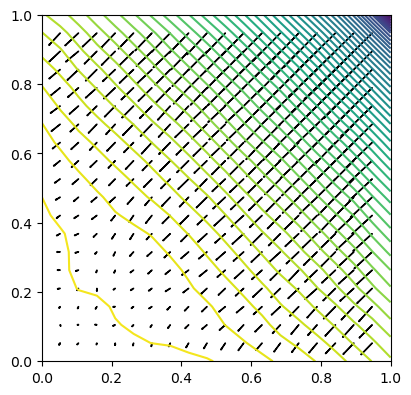

In [33]:
fig = plt.figure()
plt.xlim(0, 1) # plt.xlim(-1.5,1.5)
plt.ylim(0, 1) # plt.ylim(-1.5,1.5)
surf = plt.contour(X, Y, lambda_probability, 50,cmap='viridis')
#gradient = plt.quiver(X, Y, lambda_probability_gradient_lambda1, lambda_probability_gradient_lambda2)
gradient = np.vectorize(plt.arrow)(X[1:-1,1:-1], Y[1:-1,1:-1], finite_difference_probability_gradient_lambda1[1:-1,:], finite_difference_probability_gradient_lambda2[:,1:-1])

fig = plt.figure()
plt.xlim(0, 1) # plt.xlim(-1.5,1.5)
plt.ylim(0, 1) # plt.ylim(-1.5,1.5)
surf = plt.contour(X, Y, lambda_probability, 50,cmap='viridis')
gradient = np.vectorize(plt.arrow)(X, Y, score_probability_gradient_lambda1_u, score_probability_gradient_lambda2_u)

fig = plt.figure()
plt.xlim(0, 1) # plt.xlim(-1.5,1.5)
plt.ylim(0, 1) # plt.ylim(-1.5,1.5)
surf = plt.contour(X, Y, lambda_probability, 50,cmap='viridis')
gradient = np.vectorize(plt.arrow)(X, Y, score_probability_gradient_lambda1_t, score_probability_gradient_lambda2_t)

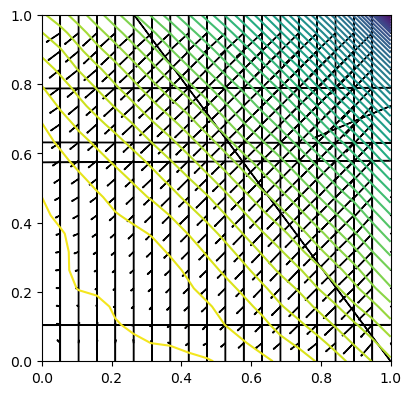

In [34]:
fig = plt.figure()
plt.xlim(0, 1) # plt.xlim(-1.5,1.5)
plt.ylim(0, 1) # plt.ylim(-1.5,1.5)
surf = plt.contour(X, Y, lambda_probability, 50,cmap='viridis')
gradient = np.vectorize(plt.arrow)(X, Y, score_probability_gradient_lambda1_u-score_probability_gradient_lambda1_t, score_probability_gradient_lambda2_u-score_probability_gradient_lambda2_t)

# Local gradient comparison

## We compare the finite difference gradient to the one obtained using the score function at a specific lambda value.  

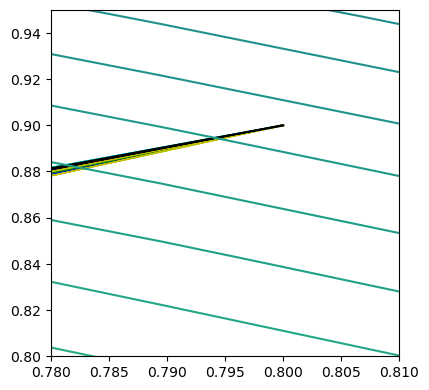

In [35]:
lambda_fixed = [0.8, 0.2, 0.9, 0.1]
d_lambda = 1e-2

SEEDS = [321654987, 123456789, 147258369, 987654321, 741852963, 357241689]
colors = ['r', 'b', 'g', 'c', 'y', 'k']

plt.close()  

fig, ax = plt.subplots()
ax.set_xlim(0.78, 0.81) # plt.xlim(-1.5,1.5)
ax.set_ylim(0.8, 0.95) # plt.ylim(-1.5,1.5)
surf = ax.contour(X, Y, lambda_probability, 50,cmap='viridis')

N = int(1e6)

for i, seed in enumerate(SEEDS): 
     
    ot.RandomGenerator.SetSeed(seed)
    ref_sample_U1 = np.squeeze(e_pos.getSample(N))
    ref_sample_G1 = np.squeeze(e_theta.getSample(N))
    ref_sample_U2 = np.squeeze(e_pos.getSample(N))
    ref_sample_G2 = np.squeeze(e_theta.getSample(N))
    
    ref_samples = np.column_stack([ref_sample_U1, ref_sample_G1, ref_sample_U2, ref_sample_G2])
    prob0, gradient_score = f_test(lambda_fixed, ref_samples=ref_samples)
    gradient_score_reduced = gradient_score[[0,2]] - gradient_score[[1,3]]

    ar_score = ax.arrow(0.8, 0.9, gradient_score_reduced[0], gradient_score_reduced[1], color=colors[i], width=0.0002)

    prob_dl1, _ = f_test([lambda_fixed[0]+d_lambda, lambda_fixed[1]-d_lambda, lambda_fixed[2], lambda_fixed[3]], ref_samples=ref_samples)
    prob_dl2, _ = f_test([lambda_fixed[0], lambda_fixed[1], lambda_fixed[2]+d_lambda, lambda_fixed[3]-d_lambda], ref_samples=ref_samples)

    ar_finite = ax.arrow(0.8, 0.9, (prob_dl1 - prob0)/d_lambda, (prob_dl2 - prob0)/d_lambda, color=colors[i], width=0.00005)

    

In [36]:
print(lambda_probability.min(), lambda_probability.max())
print(1-lambda_probability.min(), 1-lambda_probability.max())


0.101386 0.202614
0.898614 0.797386
